### Student Information
Name: 王俊皓

Student ID: 108021121

GitHub ID: mYstoRi

Kaggle name: mYstoRi

Kaggle private scoreboard snapshot: 

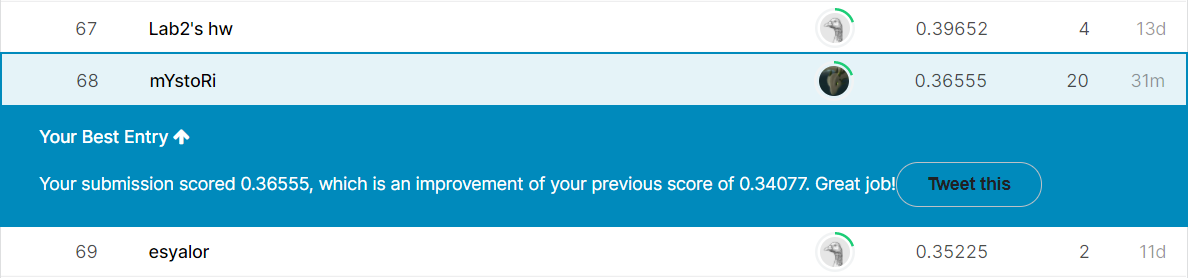

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2021-Lab2-master Repo](https://github.com/fhcalderon87/DM2021-Lab2-master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/c/dm2021-lab2-hw2/) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 24th 11:59 pm, Friday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 29th 11:59 pm, Wednesday)__. 

### Begin Assignment Here
---------------------

Let's get some lines shall we

-----------------

Data loading
-------------

Note: All errors left are intended to more precisely present the process.

In [1]:
import json

with open('tweets_DM.json', 'r') as f:
    raw = json.load(f)
print(raw[0])

JSONDecodeError: Extra data: line 2 column 1 (char 269)

Well, for some reason the file is not well-formated. So we have to break it down manually.

In [2]:
rawtxt = []
with open('tweets_DM.json', 'r') as f:
    for line in f:
        rawtxt.append(line)
text = []
textid = []
for line in rawtxt:
    #treats the file as pure string
    textid.append(line.split('tweet_id\": \"')[1].split('\", \"text')[0])
    text.append(line.split('\"text\": \"')[1].split('\"}}, \"_crawldate\"')[0])
    
print(text[0], textid[0])

People who post \"add me on #Snapchat\" must be dehydrated. Cuz man.... that's <LH> 0x376b20


Checking result

In [3]:
print(len(text))
print(len(textid))

1867535
1867535


Now separate them into training set and test set according to `data_identification.csv`.

In [4]:
import csv

testortrain = {} # store result in dictionary form for faster searching.
with open('data_identification.csv', newline='') as csvfile:
    
    rows = csv.reader(csvfile)

    for row in rows:
        testortrain[row[0]] = row[1]
        
testortrain['0x28cc61']

'test'

In [5]:
train = []
trainid = []
test = []
testid = []
for ids in range(len(textid)):
    #print('file no.' + str(ids))#this is for time tracking
    if testortrain[textid[ids]] == 'test':
        test.append(text[ids])
        testid.append(textid[ids])
    else:
        train.append(text[ids])
        trainid.append(textid[ids])
    #if ids%1000 == 0:
        #print(ids)
        
print(len(train))
print(len(test))


1455563
411972


For future development, running codes will be faster if we are just testing out stuff. It helps to make this sample function.

In [6]:
from random import sample

def resample(size):
    sample_train = []
    sample_trainid = []
    sampleid = sample([i for i in range(len(trainid))], size) # sample on tweet id
    for i, ids in enumerate(sampleid):
        sample_train.append(train[ids])
        sample_trainid.append(trainid[ids])
        #if i%(3000)<1:
            #print(str(int(i/size*10000)/100) + '% done')
        
    return sample_train, sample_trainid

In [7]:
sample_train, sample_trainid = resample(10000)

Do the same thing to `emotion.csv` for answer.

In [8]:
import csv

answersheet = {}
with open('emotion.csv', newline='') as csvfile:
    
    rows = csv.reader(csvfile)

    for row in rows:
        if row[0] != 'tweet_id':
            answersheet[row[0]] = row[1]
        
answersheet['0x2ee1dd']

'anticipation'

Data observations
-------

For practical reasons, we are only gonna work on a number of `sample_size` of data, since it is too time consuming to run through the whole training set containing 1455563 items.

Let's analyze some posts first to see how we identify it in our mind. It is helpful for us to understand the intuition of this task.

In [9]:
from random import randint

def for_example():
    Id = randint(0, len(sample_trainid))
    print('id:')
    print(sample_trainid[Id])
    print('\ntext:')
    print(sample_train[Id])
    print('\nemotion:')
    print(answersheet[sample_trainid[Id]])

In [10]:
for_example()

id:
0x2c7856

text:
LAWD!!!! Queen Sugar!!!!!! <LH>

emotion:
joy


Main observations:

1. Some of the tweet emotions depend on the picture they tweet.
2. Tags are probably ignorable because they're just people.
3. Emoticons may be crutial. They are of the form \uxxxx, along with punctuations.
4. Hashtags are helpful sometimes, but it can also be just indicating fields of the content.

As a conclusion, tweets have 3 main characteristic:
1. There are tags. Tag includes a username.
2. There are hashtags. They indicates feelings or topics.
3. There are emoticons. They're used in line and is the most pictural way to express emotions.

Hence the whole text can be broken down to 4 parts, that is: tags, hashtags, emoticons and contents, which the content means the rest of the text.
In the followings, I'll go through all of them and then assemble them back together to get the final result.

Tokenization in a variety of fields can, and should, be specialized to match each scenario. And twitter is no difference. 

Emoticon Scanning & Analysis
-------

From observation stated, I want to start from emoticons. For each emoticon, try to list out the portion of emotions. Some emoticons might be very related to a specific emotion and is used under strict circumstances.

Building emoticon dictionary:

In [11]:
emodict = {}

'''
emodict format:
{
    emoticon1 : {
        joy:x11,
        sadness:x12,
        ...
    },
    emoticon2 : {
        joy:x21,
        sadness:x22,
        ...
    },
    ...
}
'''

for tweet in range(len(sample_train)):
    
    #capture emoticons
    #The way of capturing is to capture the next 4 characters after '\u'.
    firstsplit = sample_train[tweet].split('\\u')[1:]
    tweet_emotion = answersheet[sample_trainid[tweet]]
    secondsplit = []
    for raw_emoticon in firstsplit:
        secondsplit.append(raw_emoticon[:4])
        
    #construct the dictionary
    for emoticon in secondsplit:
        #initialization
        if emoticon not in emodict:
            emodict[emoticon] = {}
        #initialization
        if tweet_emotion not in emodict[emoticon]:
            emodict[emoticon][tweet_emotion] = 1
        else:
            emodict[emoticon][tweet_emotion] += 1

emodict['d83d']

{'sadness': 323,
 'anticipation': 492,
 'joy': 1501,
 'trust': 497,
 'anger': 112,
 'fear': 177,
 'surprise': 114,
 'disgust': 191}

`d83d` is '😂', which has high use rate overall. Here shows that this emoticon is mostly used in 'joy' tweets with ~40% of the time, which isn't really that indicating.

Here I introduce the 'index of dispersion'. This values how spread, or indicating, an emoticon was. if the value is high, means that it well indicates the emotion. It can be used to decide how important the emoticon is in a tweet text for expressing emotions.

In [ ]:
from math import sqrt

emosig = {}
for emoticon in emodict:
    s = 0
    s2 = 0
    for emotion in emodict[emoticon]:
        s += emodict[emoticon][emotion]
        s2 += emodict[emoticon][emotion]**2
    emosig[emoticon] = s2/(s**2)
print(emosig)# hid the output cuz it is horrible to read

As it can be seen, there are a lot of emoticons probably just being used in one tweet, so the score is 1.0. We can solve this by two ways:
1. Increase sample number.
2. Not taking emoticons that participated in less than k tweets into account. (appropriate integer k)

We first try method 2 due to simplicity. Eventually we will work on the whole training set and this is just gonna happen more, so we deal with 2 first.

In [ ]:
k = 10

emosig = {}
for emoticon in emodict:
    s = 0
    s2 = 0
    for emotion in emodict[emoticon]:
        s += emodict[emoticon][emotion]
        s2 += emodict[emoticon][emotion]**2
    if s>k:
        emosig[emoticon] = s2/(s**2)
print(emosig)# hid the output cuz it is horrible to read

k=10 seems legit while also provide decent information.

We shall re-sample to see if this information is actually useful. Also, build an emoticon extractor for this task. The extractor can be further expanded to a tokenizer, if needed.

In [14]:
sample_train, sample_trainid = resample(10000)

In [15]:
#extract emoticons from text
def extract_emoticon(text):
    firstsplit = text.split('\\u')[1:]
    secondsplit = []
    for raw_emoticon in firstsplit:
        secondsplit.append(raw_emoticon[:4])
    return secondsplit

# We do this again to the resampled set
emodict = {}
for tweet in range(len(sample_train)):
    
    #capture emoticons
    tweet_emotion = answersheet[sample_trainid[tweet]]
    emoticons = extract_emoticon(sample_train[tweet])
        
    #construct the dictionary
    for emoticon in emoticons:
        #initialization
        if emoticon not in emodict:
            emodict[emoticon] = {}
        if tweet_emotion not in emodict[emoticon]:
            emodict[emoticon][tweet_emotion] = 1
        else:
            emodict[emoticon][tweet_emotion] += 1

#calculate index of dispersion
k = 10
emosig = {}
for emoticon in emodict:
    s = 0
    s2 = 0
    for emotion in emodict[emoticon]:
        s += emodict[emoticon][emotion]
        s2 += emodict[emoticon][emotion]**2
    if s>k:
        emosig[emoticon] = s2/(s**2)


In [16]:
c = 0
for emo in emosig:
    c += 1
    if c>5:
        break
    else:
        print(emo)
        print(emodict[emo])
        print(emosig[emo])

d83c
{'surprise': 40, 'trust': 259, 'joy': 533, 'disgust': 61, 'anticipation': 187, 'fear': 42, 'sadness': 62, 'anger': 119}
0.24221157974778082
df84
{'surprise': 2, 'joy': 6, 'trust': 2, 'anticipation': 4, 'sadness': 1}
0.27111111111111114
df81
{'surprise': 2, 'joy': 4, 'trust': 2, 'sadness': 1, 'anticipation': 2}
0.2396694214876033
d83d
{'joy': 1683, 'surprise': 133, 'trust': 533, 'fear': 243, 'anger': 134, 'sadness': 330, 'anticipation': 439, 'disgust': 193}
0.2610140586106785
de03
{'joy': 11, 'trust': 3, 'anticipation': 7, 'sadness': 2}
0.34593572778827975


Sounds like a reasonable approach. We will use this as an analyzer later on.

# Widgets Establishment

In the process of emoticon analysis, partially due to not knowing a lot of packages, I hard coded a lot and the code became more and more messy. Here I will sort up some repeated lines into functions for future convenience.

Many codes here I don't want it to be too general, since that would take too much effort and will not be utilized here. A lot of global variables being used, as a trade off to reduce the number of variables.

In [17]:
def iod(d):
    k = 10
    sig = {}
    for emoticon in d:
        s = 0
        s2 = 0
        for emotion in d[emoticon]:
            s += d[emoticon][emotion]
            s2 += d[emoticon][emotion]**2
        if s>k:
            sig[emoticon] = s2/(s**2)
        else:
            sig[emoticon] = 0
    return sig

def emotion_count(sample_train, sample_trainid, capture):
    emodict = {}
    print('sample size: ' + str(len(sample_train)))
    for tweet in range(len(sample_train)):
    
        tweet_emotion = answersheet[sample_trainid[tweet]]
        
        #capture words using [capture]
        words = capture(sample_train[tweet])
        
        #construct the dictionary
        for word in words:
            #initialization
            if word not in emodict:
                emodict[word] = {}
            if tweet_emotion not in emodict[word]:
                emodict[word][tweet_emotion] = 1
            else:
                emodict[word][tweet_emotion] += 1
    return emodict

# Tags

After emoticon being separated out, the next characteristic of tweets are tags. Some tags are just a friend of the author's, which might not contain any information, while some are celebrities, which could potentially imply the topic of the post, and indirectly imply the emotion.

But again, this effect will be portraited by index of dispersion, so we are free to do the same thing.

First we need to capture tags. A tag ends whenever there's a space/punctuation. We also build a function for it to simplify future codes.

In [18]:
punctset = '!?., '

def extract_tags(text):
    firstsplit = text.split('@')[1:]
    secondsplit = []
    for word in firstsplit:
        s = '@'
        for char in word:
            if char not in punctset:
                s += char
            else:
                break
        secondsplit.append(s)
    return secondsplit

In [19]:
k = randint(0, len(sample_train))
print(sample_train[k])
print(extract_tags(sample_train[k]))

\"Which made heaven, and earth, the sea, and all that therein is: which keepeth truth for ever:\" ~Psalms 146:6 <LH>
[]


Again, we use similar tactics for the tags. But this time, we keep an eye on the total tag count.

In [21]:
tagdict = emotion_count(sample_train, sample_trainid, extract_tags)
tagsig = iod(tagdict)

sample size: 10000


In [22]:
#Is there a better way to show dictionaries? I'm trying to show it the most efficient way possible.
c = 0
for tag in tagsig:
    c += 1
    if c>5:
        break
    else:
        print(tag)
        print(tagdict[tag])
        print(tagsig[tag])

@realDonaldTrump
{'surprise': 12, 'disgust': 37, 'anticipation': 17, 'sadness': 104, 'trust': 4, 'joy': 10, 'anger': 1, 'fear': 1}
0.3681350445138166
@MooreSenate
{'surprise': 1, 'disgust': 2, 'anticipation': 1}
0
@BartRhett
{'sadness': 1}
0
@CornellWAFT
{'sadness': 1}
0
@hootsuite
{'anger': 1}
0


As it can be seen with more detail (not shown above), some users have been tagged many times, while most just been tagged once or twice.

Also this @MostRequestLive is always sad for some reason.

In [24]:
#execute the cell to get a new result. Might take roughly 1-2 minutes.
sample_train, sample_trainid = resample(10000)
tagdict = emotion_count(sample_train, sample_trainid, extract_tags)
tagsig = iod(tagdict)
tagdict['@MostRequestLive']

sample size: 10000


{'sadness': 23}

I was about to straight abandon this tag thing at first. But some of them are actually indicating pretty well. There's not really a way of determining if the technique helps or not without examine it on the competition, but this method seems to have some potential.

# Hashtags

Same again with hashtags. Things like #fail, #grateful should be pretty indicating. Now that we harnessed the technique, there should be no difficulty for us.

In [25]:
punctset = '!?., \\'

def extract_hashtags(text):
    firstsplit = text.split('#')[1:]
    secondsplit = []
    for word in firstsplit:
        s = '#'
        for char in word:
            if char not in punctset:
                s += char
            else:
                break
        secondsplit.append(s)
    return secondsplit

In [26]:
k = randint(0, len(sample_train))
print(sample_train[k])
print(extract_hashtags(sample_train[k]))

Felix wants to know God's message for mankind; what do YOU think it is? #question #indiefilm <LH> #darkcomedy <LH> #supportindiefilm
['#question', '#indiefilm', '#darkcomedy', '#supportindiefilm']


In [28]:
sample_train, sample_trainid = resample(10000)
hashtagdict = emotion_count(sample_train, sample_trainid, extract_hashtags)
hashtagsig = iod(tagdict)

sample size: 10000


Listing out some remarkable ones:

In [29]:
print(hashtagdict['#life'])
print(hashtagdict['#Jesus'])
print(hashtagdict['#love'])
print(hashtagdict['#dream'])
print(hashtagdict['#special'])

{'joy': 43, 'anticipation': 10, 'trust': 9, 'sadness': 6, 'surprise': 2, 'anger': 1, 'disgust': 1}
{'anticipation': 27, 'trust': 1, 'joy': 1}
{'joy': 71, 'trust': 2}
{'anticipation': 38}
{'joy': 31}


# Tokenization?

With all these customization done, the last part is the 'content'. Now we have the ability of extracting hashtags, emoticons and tags with fairly high accuracy, we can use packages to help tokenization and then pick the ones that is the actual content.

In [30]:
import tensorflow as tf

tokenizer = tf.keras.preprocessing.text.Tokenizer()
sample_train_tokens = [tokenizer.fit_on_texts(sample_train[i]) for i in range(len(sample_train))]

In [31]:
print(tokenizer.fit_on_texts(sample_train[0]))

None


Well that didn't work out... solving these is always a pain to me.

Thankfully, this task is for English so the tokenize is not hard to code. Might as well try.

In [32]:
def my_tokenize(text):
    letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-1234567890%:'
    tokens = []
    s = ''
    emo = extract_emoticon(text)
    tag = extract_tags(text)
    htag = extract_hashtags(text)
    for char in text:
        if char in letters:
            s += char
        else:
            dup = False # I want the content to not contain emoticons/tags/hashtags. It didn't ended up that way but just in case.
            for e in emo:
                if e in s:
                    dup = True
            for e in tag:
                if s in e:
                    dup = True
            for e in htag:
                if s in e:
                    dup = True
            if (not dup)&(s != ''):
                tokens.append(s)
            s = ''
    
    return (tokens, emo, tag, htag)

In [33]:
k = randint(0, len(sample_train))
print(sample_train[k])
print(my_tokenize(sample_train[k]))

Happy to be signing a contract with @sneakerdeck as I will be writing blogs for them <LH> #blogger
(['Happy', 'to', 'be', 'signing', 'contract', 'with', 'as', 'I', 'will', 'be', 'writing', 'blogs', 'for', 'them', 'LH'], [], ['@sneakerdeck'], ['#blogger'])


In [34]:
sample_train_tokens = []
for i in range(len(sample_train)):
    sample_train_tokens.append(my_tokenize(sample_train[i]))

In [35]:
sample_train_tokens[5]

(['That',
  'it',
  'Ladies',
  'Onto',
  'the',
  'Main',
  'Draw',
  'Keep',
  'it',
  'rollin',
  'Proud',
  'Loud',
  'in',
  'the',
  'LH'],
 ['d83c',
  'ddfa',
  'd83c',
  'ddf8',
  'd83d',
  'dc4a',
  'd83d',
  'dc51',
  'd83d',
  'dc51'],
 ['@kerrileewalsh', '@NicoleBranagh'],
 ['#badassmoms'])

With a little scrolling through twitter and maybe distracting someone's attention in the library, the tokenization is quite successful it seems. We can always come back to this topic for improvement, whether to use some packages or just simple tweaks.(we do actually!)

An sad but real fact of doing this is that, most libraries bind tokenization and vectorization together, which limits customizations of tokenization. But with the knowledge of each method, we can still perform them on our own, and even modify it to fit this scenario even more. It takes a lot to format our data structure, but in return, we separated out the specials in the text.

# Decision Tree Classifier

In [36]:
from sklearn.feature_extraction.text import CountVectorizer#copied

In [37]:
#copied
# build analyzers (bag-of-words)
BOW_vectorizer = CountVectorizer() 
type(BOW_vectorizer)

sklearn.feature_extraction.text.CountVectorizer

We will add up all things in our tokenizer, and adding more significance later with our emoticon/tag/hashtag specification.

In [38]:
# This joins our tokenization result into a large string with only space separating them so it is easier for vectorizer to read.
def convert_CV_readables(data):
    sample_train_content_list = [data[i][0]+data[i][1]+data[i][2]+data[i][3] for i in range(len(data))]
    sample_train_contents = []
    for i in range(len(sample_train_content_list)):
        s = ''
        for token in range(len(sample_train_content_list[i])):
            s += sample_train_content_list[i][token]
            if token != (len(sample_train_content_list[i])-1):
                s += ' '
        sample_train_contents.append(s)
    return sample_train_contents

In [39]:
sample_train_contents = convert_CV_readables(sample_train_tokens)

In [40]:
#copied
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.(well only 10000 for now)
print(type(BOW_vectorizer.fit(sample_train_contents)))

# 2. Transform documents to document-term matrix.
train_data_BOW_features = BOW_vectorizer.transform(sample_train_contents)

<class 'sklearn.feature_extraction.text.CountVectorizer'>


In [41]:
#copied
feature_names = BOW_vectorizer.get_feature_names_out()

In [42]:
len(feature_names)

22879

In [43]:
#copied
from sklearn.tree import DecisionTreeClassifier

We shall take some training data as our test data temporarily, since we do not have the answer to the real testing data. This is for error analysis.

In [44]:
sample_test, sample_testid = resample(1000)
sample_test_tokens = []
for i in range(len(sample_test)):
    sample_test_tokens.append(my_tokenize(sample_test[i]))
sample_test_contents = convert_CV_readables(sample_test_tokens)
sample_test_contents[:5]

['Another O Borings night LH @FeitsBarstool @chrissyteigen @FeitsBarstool',
 'We Didn We Were Making We Just We Were LH 2019 #Realise #Memories #Knew #Creating #Objects #Life #AndreChiang #Chef',
 'NC State is now number 20 and we knocked Louisville out of the top 25 LH d83d dc3e d83d dc3e #gopack',
 'Priceless LH d83d de4b 200d 2640 fe0f @VtheLearner @getnicced @angiecthomas @andimJULIE @JasonReynolds83',
 'Ben McAdoo should be fired for that greased back hair alone #gross #NYGiants']

In [45]:
#copied
test_data_BOW_features = BOW_vectorizer.transform(sample_test_contents)

Also need answers for it.

In [46]:
sample_train_answers = [answersheet[ids] for ids in sample_trainid]
sample_test_answers = [answersheet[ids] for ids in sample_testid]

In [47]:
#copied
# for a classificaiton problem, you need to provide both training & testing data
X_train = train_data_BOW_features
y_train = sample_train_answers
X_test = test_data_BOW_features
y_test = sample_test_answers

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', len(y_train))
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', len(y_test))

X_train.shape:  (10000, 22879)
y_train.shape:  10000
X_test.shape:  (1000, 22879)
y_test.shape:  1000


In [48]:
#copied
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=0)

## training!
DT_model = DT_model.fit(X_train, y_train)

In [49]:
y_train_pred = DT_model.predict(X_train)
y_test_pred = DT_model.predict(X_test)

In [50]:
k = randint(0, len(sample_testid))
print(sample_test_tokens[k])
print(answersheet[sample_testid[k]])
print(X_test[k])
print(y_test_pred[k])

(['LH', 'LH', 'to', 'see', 'another', 'day'], ['d83d', 'de4f'], [], [])
trust
  (0, 1667)	1
  (0, 5240)	1
  (0, 5409)	1
  (0, 5740)	1
  (0, 12148)	2
  (0, 18073)	1
  (0, 20681)	1
joy


Introducing f1-measure to see how good it is. Also we're using mean f1-score it seems.

In [131]:
lexicon = { # This appears a lot later so you(reader) will probably want to keep in mind.
    'anger':0,
    'anticipation':1,
    'disgust':2,
    'fear':3,
    'sadness':4,
    'surprise':5,
    'trust':6,
    'joy':7
}
def f1score(testids, pred, detailed): # If detailed=True, it will return separated f1 score for all emotions.
    tp, fp, fn = [0]*8, [0]*8, [0]*8
    for ids in range(len(testids)):
        if pred[ids] == answersheet[testids[ids]]:
            tp[lexicon[pred[ids]]] += 1
        else:
            fp[lexicon[pred[ids]]] += 1
            fn[lexicon[answersheet[testids[ids]]]] += 1
    f1 = [tp[i]/(tp[i]+(1/2)*(fp[i]+fn[i])) for i in range(8)]
    if detailed:
        return f1
    else:
        return sum(f1)/8

In [52]:
f1score(sample_testid, y_test_pred, True)

[4, 70, 14, 9, 40, 2, 33, 222]
[38, 101, 54, 20, 86, 11, 78, 218]
[20, 103, 81, 32, 86, 25, 113, 146]


[0.12121212121212122,
 0.4069767441860465,
 0.17177914110429449,
 0.2571428571428571,
 0.31746031746031744,
 0.1,
 0.25680933852140075,
 0.5495049504950495]

though didn't seem accurate, it's still get similar ones sometimes. We can now head towards our first submission.

Let's sort this again to make it cleaner.

In [53]:
def buildDTmodel(train_size): #this is just concluding all codes above. I know this is a mess right there.
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    BOW_vectorizer = CountVectorizer() 
    BOW_vectorizer.fit(sample_train_contents)
    train_data_BOW_features_fn = BOW_vectorizer.transform(sample_train_contents_fn)
    feature_names = BOW_vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    DT_model = DecisionTreeClassifier(random_state=0)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    DT_model.fit(train_data_BOW_features_fn, sample_train_answers)
    
    print('model built.')
    return DT_model

def my_vectorize(test):
    sample_test_tokens_fn = []
    for i in range(len(test)):
        sample_test_tokens_fn.append(my_tokenize(test[i]))
    sample_test_contents_fn = convert_CV_readables(sample_test_tokens_fn)
    test_data_BOW_features_fn = BOW_vectorizer.transform(sample_test_contents_fn)
    return test_data_BOW_features_fn

In [56]:
DT = buildDTmodel(1000)
sample_test, sample_testid = resample(1000)
X_test = my_vectorize(sample_test)
test_pred = DT.predict(X_test)

sampling...
tokenizing...
vectorizing...
total feature count: 22879
training model...
model built.


In [58]:
k = randint(0, len(test_pred))
print(answersheet[sample_testid[k]])
print(test_pred[k])

anticipation
joy


# First attempt of submission

For consistency and since we have way more than just 10000 training data, it is probably worthwhile to devote time for a large training.

First we filter out the test tweets:

Just curious about how long it will take, don't mind me:

In [59]:
from time import time

In [60]:
k = randint(0, len(test))
print(len(test))
print(testid[k])
print(test[k])

411972
0x1dbf8c
@MMViverito will U oppose Ulrich bill to require hotels to post signs when homeless are being sheltered #stigma <LH>


Now we're ready to go.

In [61]:
t0 = time()
DT = buildDTmodel(100000)
X_test = my_vectorize(test)
test_pred = DT.predict(X_test)
t1 = time()
print('time spent: ' + str(t1-t0) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 22879
training model...
model built.
time spent: 74.40987992286682s


In [62]:
len(test_pred)

411972

Export as csv file:

In [63]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'emotion'])
    for e in range(len(test_pred)):
        writer.writerow([testid[e], test_pred[e]])

The submit score with this is about ~0.29, with 100k training example. 
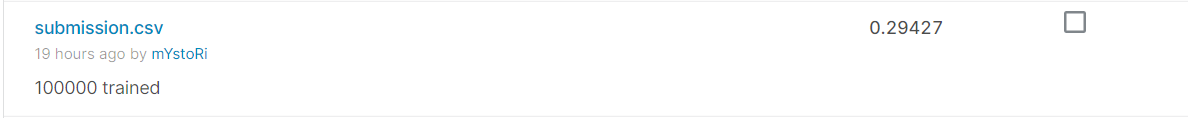

# TF-IDF Vectorizer

In the first attempt, we used `CountVectorizer` as our vectorizer, which simply count every words that appeared. It turns out some words might lost significance. TF-IDF is a fair way to deal with this.

Fortunately, this is quite easy to implement since we have pretty much the same thing set up.

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

def buildDTmodel_TFIDF(train_size): #this is just concluding all codes above.
    t0 = time()
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    DT_model = DecisionTreeClassifier(random_state=0)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    DT_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    t1 = time()
    print('time spent: ' + str(int((t1-t0)*100)/100) + 's')
    return (DT_model, vectorizer)

def my_vectorize_TFIDF(test, vectorizer):
    sample_test_tokens_fn = [] 
    for i in range(len(test)):
        sample_test_tokens_fn.append(my_tokenize(test[i]))
    sample_test_contents_fn = convert_CV_readables(sample_test_tokens_fn)
    test_data_features_fn = vectorizer.transform(sample_test_contents_fn)
    return test_data_features_fn

I do run this with the whole training set, and it roughly took 2 hours. With slightly worse result, samples 100k is much more time-preserving.

In [66]:
t0 = time()
DT, tfidf = buildDTmodel_TFIDF(100000)
X_test = my_vectorize_TFIDF(test, tfidf)
test_pred = DT.predict(X_test)
t1 = time()
print('time spent: ' + str(t1-t0) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
time spent: 92.93s
time spent: 107.83706998825073s


This is also pretty repeatable:

In [67]:
def write_submission(): # the prediction MUST be called test_pred
    with open('submission.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'emotion'])
        for e in range(len(test_pred)):
            writer.writerow([testid[e], test_pred[e]])

In [68]:
write_submission()

With the whole training set, it ended up with score of 0.31.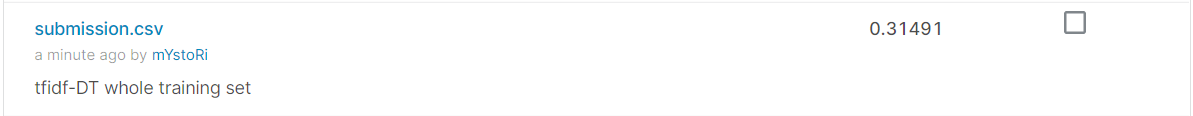

With 100k of training set, it ended up with score of ~0.28.

Sometimes reality is just apart from theory, taking simple paths will maybe have a better result. I mean this is kind of trial and error anyway. Let's not tokenize ourself and see what happens.

In [133]:
def buildDTmodel_TFIDF_default(train_size):
    t0 = time()
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
#    print('tokenizing...')
#    sample_train_tokens_fn = []
#    for i in range(len(sample_train_fn)):
#        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
#    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_fn)
    train_data_features_fn = vectorizer.transform(sample_train_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    DT_model = DecisionTreeClassifier(random_state=0)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    DT_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    t1 = time()
    print('time spent: ' + str(int((t1-t0)*100)/100) + 's')
    return (DT_model, vectorizer)

In [134]:
t0 = time()
DT, tfidf = buildDTmodel_TFIDF(100000)
X_test = tfidf.transform(test)
test_pred = DT.predict(X_test)
t1 = time()
print('time spent: ' + str(t1-t0) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
time spent: 92.97s
time spent: 97.92132091522217s


In [135]:
write_submission()

That is also around 0.28.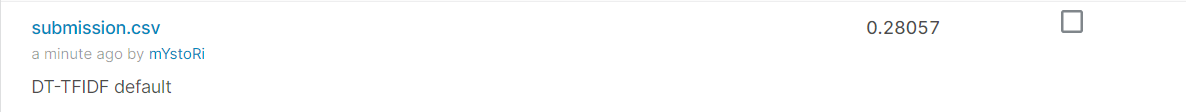

# k-nearest neighbor

As a function in `sklearn`, this has similar setup process as others stated, so we may as well try it.

In [135]:
from sklearn.neighbors import KNeighborsClassifier

def buildKNNmodel_TFIDF(train_size): #this is just concluding all codes above.
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    knn_model = KNeighborsClassifier()
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    knn_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    return (knn_model, vectorizer)

In [138]:
t0 = time()
KNN, tfidf = buildKNNmodel_TFIDF(len(train))
X_test = my_vectorize_TFIDF(test, tfidf)
print('vectorization done.')
t1 = time()
print('time spent: ' + str(t1-t0) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
vectorization done.
time spent: 81.189453125s


In [146]:
print(X_test.shape)
test_pred = []
test_pred_p = []
for i in range(X_test.shape[0]):
    t0 = time()
    test_pred.append(KNN.predict(X_test[i]))
    test_pred_p.append(KNN.predict_proba(X_test[i]))
    t1 = time()
    print(i)
    print(str(t1-t0) + 's spent, estimated ' + str((X_test.shape[0]-i)*(t1-t0)) + 's remains')
print('prediction made.')

(411972, 100000)
0
0.6886851787567139s spent, estimated 283719.0104627609s remains
1
0.6708633899688721s spent, estimated 276376.2616288662s remains
2
0.6482529640197754s spent, estimated 267060.77358722687s remains
3
0.666243314743042s spent, estimated 274471.59213137627s remains
4
0.6582386493682861s spent, estimated 271173.2599029541s remains
5
0.6472690105438232s spent, estimated 266653.47246670723s remains
6
0.6482653617858887s spent, estimated 267063.2880334854s remains
7
0.6604084968566895s spent, estimated 272065.18640756607s remains


KeyboardInterrupt: 

Well, that is literally gonna take 3 whole days wow. Nope, let's not try it then.

It is also likely it ended up with a memory error too. It is probably wise to not risk it.

Since it's probably pretty simple, I'm gonna try some more methods provided by `sklearn`. It doesn't hurt anyways.

# Naive Bayes

This most likely would not work since the words in a document is definitely related to each other. Again, it doesn't hurt to try.

In [118]:
from sklearn.naive_bayes import GaussianNB

In [289]:


def buildGNBmodel_TFIDF(train_size): #this is just concluding all codes above.
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    gnb_model = GaussianNB()
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    gnb_model.fit(train_data_features_fn.toarray(), sample_train_answers)
    
    print('model built.')
    return (gnb_model, vectorizer)

In [290]:
t0 = time()
GNB, tfidf = buildGNBmodel_TFIDF(len(train))
X_test = my_vectorize_TFIDF(test, tfidf)
print('vectorization done.')
t1 = time()
print('time spent: ' + str(t1-t0) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...


MemoryError: Unable to allocate 1.06 TiB for an array with shape (1455563, 100000) and data type float64

Well 1TB needed oh my. Quick calculation, we have ~2GB to spare, that's 2% of this, which means we can only use about 150k data and 20k features. We cannot change dtype as well since precision is kind of important too.

(From the future) Well turns out we don't even have 2GB for it. It's not even close.

# Twitter Specification & Aggregation of Methods

In the beginning, we filtered out emoticons/tags/hashtags from text. Not knowing how they perform in TF-IDF/Count, we can do some little tweak to our model to improve their accuracy.

So the way we do that, is to assign a score to each emotion, given the vectorized data, by combining different method results. Using `self.predict_proba()` function in `sklearn`, we can get how confused deciding it is. Our score can be appended on it after multiplied by some coefficient, determined by simple machine learning. By doing this, Our score will at least be as good as the original score, which means the learning result will be all coefficients = 0.

In [69]:
X_test = my_vectorize_TFIDF(test, tfidf)
test_pred_p = DT.predict_proba(X_test)

In [70]:
print(test_pred_p[:10])
print(test_pred[:10])

[[0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]
['anticipation' 'anticipation' 'sadness' 'joy' 'joy' 'trust' 'joy' 'joy'
 'disgust' 'joy']


Oh wait... It's dicision tree yeah I forgot. You get definite answers.

We don't have a model that tells probability since knn/NB failed.

Nevermind, let's just head into it and see what happens then.

Let's first establish our dictionaries using methods developed, just in case I deleted it by accident:

In [71]:
sample_train, sample_trainid = resample(len(train))
emodict = emotion_count(sample_train, sample_trainid, extract_emoticon)
tagdict = emotion_count(sample_train, sample_trainid, extract_tags)
htgdict = emotion_count(sample_train, sample_trainid, extract_hashtags)

sample size: 1455563
sample size: 1455563
sample size: 1455563


In [72]:
print(len(emodict))
f = []
for text in train:
    f += my_tokenize(text)[1]
print(len(set(f)))

3670
3670


In [73]:
print(emodict['2501'])
print(tagdict['@MostRequestLive'])
print(htgdict['#love'])

{'joy': 190, 'disgust': 4, 'anticipation': 4, 'sadness': 1, 'anger': 1}
{'sadness': 5364, 'joy': 2}
{'joy': 11059, 'anticipation': 166, 'disgust': 3, 'anger': 1, 'fear': 11, 'surprise': 7, 'trust': 97, 'sadness': 11}


So as explained, we will establish a system that convert these into scores.

In [74]:
emoiod = iod(emodict)
tagiod = iod(tagdict)
htgiod = iod(htgdict)

def myscore_part(tokens):
    scorepart = []
    for tweet in tokens:
        emoscore = [0 for i in range(8)]
        tagscore = [0 for i in range(8)]
        htgscore = [0 for i in range(8)]
        #emoticons
        for emoticon in tweet[1]:
            if emoticon in emoiod:
                iod0 = emoiod[emoticon]
                s = sum([emodict[emoticon][j] for j in emodict[emoticon]])
                for i in lexicon:
                    if i in emodict[emoticon]:
                        emoscore[lexicon[i]] += iod0*emodict[emoticon][i]/s
            else:
                emoscore[lexicon[i]] += 0
            if sum(emoscore) != 0: # normalize or it will benefit the ones that has more of this.
                t = sum(emoscore)
                emoscore = [emoscore[i]/t for i in range(8)]
                
        #tags
        for tag in tweet[2]:
            if tag in tagiod:
                iod0 = tagiod[tag]
                s = sum([tagdict[tag][j] for j in tagdict[tag]])
                for i in lexicon:
                    if i in tagdict[tag]:
                        tagscore[lexicon[i]] += iod0*tagdict[tag][i]/s
            else:
                tagscore[lexicon[i]] += 0
            if sum(tagscore) != 0: # normalize or it will benefit the ones that has more of this.
                t = sum(tagscore)
                tagscore = [tagscore[i]/t for i in range(8)]
            
        #hashtags
        for htg in tweet[3]:
            if htg in htgiod:
                iod0 = htgiod[htg]
                s = sum([htgdict[htg][j] for j in htgdict[htg]])
                for i in lexicon:
                    if i in htgdict[htg]:
                        htgscore[lexicon[i]] += iod0*htgdict[htg][i]/s
            else:
                htgscore[lexicon[i]] += 0
            if sum(htgscore) != 0: # normalize or it will benefit the ones that has more of this.
                t = sum(htgscore)
                htgscore = [htgscore[i]/t for i in range(8)]
            
        scorepart.append((emoscore, tagscore, htgscore))
    return scorepart

In [75]:
sample_train_tokens = []
for i in range(len(sample_train)):
    sample_train_tokens.append(my_tokenize(sample_train[i]))

In [76]:
sample_train_scorepart = myscore_part(sample_train_tokens)

In [94]:
print(lexicon)
k = randint(0, len(train))
print(k)
print(sample_train_tokens[k])
print(sample_train_scorepart[k])
print(answersheet[sample_trainid[k]])

{'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'sadness': 4, 'surprise': 5, 'trust': 6, 'joy': 7}
805302
(['One', 'amazing', 'class', 'with', 'feel', 'so', 'to', 'have', 'been', 'able', 'to', 'share', 'the', 'emotion', 'with', 'everyone'], ['d83d', 'de06'], ['@JoelleLeB1'], ['#blessed'])
([0.024871947267740196, 0.15187978690937917, 0.06413870890858644, 0.05513472579230605, 0.10165959895100464, 0.039435816742119205, 0.13623372058007213, 0.42664569484879217], [0, 0, 0, 0, 0, 0, 0, 0.0], [0.0, 0.0027894002789400282, 0.0, 0.00012679092177000125, 0.0013947001394700141, 0.00012679092177000125, 0.00786103714974008, 0.9877012805883099])
joy


Some of them actually shows high accuracy, provided they have emoticons/tags/hashtags in it. Of course, this cannot cover the whole criteria since some posts just don't have them. But this might be a good addition to whatever present.

The next step is to append it to the model.

In [95]:
len(sample_train)

1455563

In [164]:
def finalscore(data, dataid, DTc, emoc, tagc, htgc, is_train_set):
    print('vectorizing...')
    X_test = my_vectorize_TFIDF(data, tfidf)
    pred = []
    data_tokens = []
    for i in range(len(data)):
        data_tokens.append(my_tokenize(data[i]))
    print('generating scores...')
    scorepart = myscore_part(data_tokens)
    for i in range(len(data)):
        #t0 = time()
        temp = []
        m = 'anger'
        for emotion in lexicon:
            j = lexicon[emotion]
            DTscore = 0 if DT.predict(X_test[i])[0]!=emotion else 1
            emoscore = scorepart[i][0][j]
            tagscore = scorepart[i][1][j]
            htgscore = scorepart[i][2][j]
            temp.append(DTc*DTscore + emoc*emoscore + tagc*tagscore + htgc*htgscore)
            if temp[j] > temp[lexicon[m]]:
                m = emotion
        pred.append(m)
        #t1 = time()
        #print(str(int(i*10000/len(data))/100) + '%')
        #print('estimated ' + str((len(data)-i)*(t1-t0)) + 's')
    
    #valuation (if is_train_set is True)
    if is_train_set:
        f1 = f1score(dataid, pred, False)
        return f1, pred
    else:
        return pred

In [97]:
DT, tfidf = buildDTmodel_TFIDF(100000)

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
time spent: 92.09s


In [98]:
DTc = 0.5
emoc = 1
tagc = 1
htgc = 1

data, dataid = resample(10000)

score, pred = finalscore(data, dataid, DTc, emoc, tagc, htgc, True)
print(score)

vectorizing...
generating scores...
[85, 849, 304, 154, 570, 109, 475, 2456]
[101, 746, 444, 235, 660, 120, 652, 2040]
[197, 896, 668, 288, 748, 228, 939, 1034]
0.42715886721961865


Wow 0.42 that is a huge improvement. Though we do examine it on part of the training set, the score is expected to drop a bit.

But first, let's check for bugs in case we get hyped for nothing.

In [101]:
k = randint(0, 10000)
print(dataid[k])
print(data[k])
print(answersheet[dataid[k]])
print(pred[k])

0x26e921
\u201cLove doesn\u2019t make the world go round. Love is what makes the ride worthwhile.\u201d - Franklin P. Jones <LH> <LH> <LH>
joy
joy


It seems really promising. (One can execute code above more than one time to see.)

We can apply gradiant descend on those coefficients to potentially improve our result more but... c'mon, I have to try it on test data first.

In the myscore_part function, since the index of dispersion is already excluding words that appear <10 times, the word that does not appear more than 10 times in the train set will have a score of 0 to represent the lack of data.

In [102]:
test_pred = finalscore(test, testid, DTc, emoc, tagc, htgc, False)

vectorizing...
generating scores...


In [103]:
with open('submission.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'emotion'])
    for e in range(len(test_pred)):
        writer.writerow([testid[e], test_pred[e]])

Ok it is still ~0.34. Let's see why.

There are two main problems. One is the coefficients, the other is overfitting. Let's see what we can do with overfitting first.

In [109]:
k = randint(0, len(test))
print(testid[k])
print(test[k])
print()
print(test_pred[k])
datum_tokens = my_tokenize(test[k])
features = tfidf.get_feature_names_out()
s = 0
for word in datum_tokens[0]:
    if word in features:
        s += 1
    print(word + ': ' + str(word in features))
print('word coverage: ' + str(s/len(datum_tokens[0])))

0x315dcc
@RisingDarkstar @thehill But he will never be loved. Classic middle child syndrome. <LH>

sadness
But: False
will: True
never: True
be: True
loved: True
Classic: False
middle: True
child: True
syndrome: True
LH: False
word coverage: 0.7


It seems like capitals are less likely to be included in the tfidf vectorizer since it is up to preference to use them. The word coverage differs a lot between test data.

In former part, I only took the top 100k features to vectorize to prevent memory error. With this caps/lowercase equivalence relation, we may capture more phrases.

So now, let's enhance our tokenizer.

In [334]:
def my_tokenize(text):
    letters = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ_-1234567890%:'
    tokens = []
    s = ''
    emo = extract_emoticon(text)
    tag = extract_tags(text)
    htag = extract_hashtags(text)
    for char in text:
        if char in letters:
            s += char
        else:
            dup = False
            for e in emo:
                if e in s:
                    dup = True
            for e in tag:
                if s in e:
                    dup = True
            for e in htag:
                if s in e:
                    dup = True
            if (not dup)&(s != ''):
                tokens.append(s)
            s = ''
    
    # upper/lowercase enhancement
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    return (tokens, emo, tag, htag)

Now we try things again.

In [110]:
def buildDTmodel_TFIDF(train_size): #this is just concluding all codes above.
    t0 = time()
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    DT_model = DecisionTreeClassifier(random_state=0)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    DT_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    t1 = time()
    print('time spent: ' + str(int((t1-t0)*100)/100) + 's')
    return (DT_model, vectorizer)

def my_vectorize_TFIDF(test, vectorizer):
    sample_test_tokens_fn = [] 
    for i in range(len(test)):
        sample_test_tokens_fn.append(my_tokenize(test[i]))
    sample_test_contents_fn = convert_CV_readables(sample_test_tokens_fn)
    test_data_features_fn = vectorizer.transform(sample_test_contents_fn)
    return test_data_features_fn

In [111]:
test_tokens = []
for i in test:
    test_tokens.append(my_tokenize(i))

In [112]:
k = randint(0, len(test))
print(test[k])
print(test_tokens[k])

@alainababy_ Thanks! I have to get in to see my new doc first. It's been a giant mess. Humalog is better than no insulin though! <LH>
(['Thanks', 'I', 'have', 'to', 'get', 'to', 'see', 'my', 'new', 'doc', 'first', 'It', 's', 'been', 'giant', 'mess', 'Humalog', 'is', 'better', 'than', 'no', 'insulin', 'though', 'LH'], [], ['@alainababy_'], [])


In [113]:
DT, tfidf = buildDTmodel_TFIDF(100000)

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
time spent: 92.92s


In [114]:
test_pred = finalscore(test, testid, DTc, emoc, tagc, htgc, False)

vectorizing...
generating scores...


In [115]:
write_submission()

Well it didn't differ that much actually. The score is ~0.315.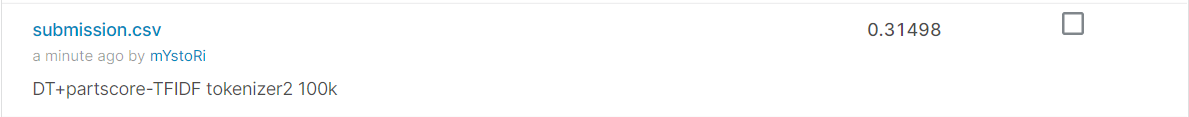

Another thing we can add is the pre/postpruning. It solves overfitting for a bit.

There's actually a lot of things we can try, let's first prevent single outliers.

In [154]:
def buildDTmodel_TFIDF(train_size): #this is just concluding all codes above.
    t0 = time()
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    DT_model = DecisionTreeClassifier(random_state=0, max_depth=100)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    DT_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    t1 = time()
    print('time spent: ' + str(int((t1-t0)*100)/100) + 's')
    return (DT_model, vectorizer)

def my_vectorize_TFIDF(test, vectorizer):
    sample_test_tokens_fn = [] 
    for i in range(len(test)):
        sample_test_tokens_fn.append(my_tokenize(test[i]))
    sample_test_contents_fn = convert_CV_readables(sample_test_tokens_fn)
    test_data_features_fn = vectorizer.transform(sample_test_contents_fn)
    return test_data_features_fn

In [155]:
DT, tfidf = buildDTmodel_TFIDF(100000)

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...


TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [140]:
t0 = time()
test_pred = finalscore(test, testid, DTc, emoc, tagc, htgc, False)
t1 = time()
print(str(int((t1-t0)*100)/100) + 's')

vectorizing...
generating scores...


In [141]:
write_submission()

### Gradiant Descend

Right, it's math time!

We are using stochastic btw.

In [132]:
learn_rate = 0.01
max_iter = 20
sample_size = 10000
coeff = [0.5, 1, 1, 1]

for i in range(max_iter):
    print('\niteration: ' + str(i+1))
    cv = randint(0, 3) # pick a variable
    sgdtrain, sgdtrainid = resample(sample_size)
    
    # derivative estimation (Euler's method)
    y = finalscore(sgdtrain, sgdtrainid, coeff[0], coeff[1], coeff[2], coeff[3], True)[0]
    coeff[cv] += learn_rate
    yh = finalscore(sgdtrain, sgdtrainid, coeff[0], coeff[1], coeff[2], coeff[3], True)[0]
    dy = (yh-y)/learn_rate
    coeff[cv] -= learn_rate
    
    # stepping
    coeff[cv] += learn_rate*dy*100
    
    #result
    print('score: ' + str(y))
    print('coefficients: ' + str(coeff))


iteration: 1
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.4171773952637079
coefficients: [0.5, 1, 1, 1.0146389489439902]

iteration: 2
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.408982451998401
coefficients: [0.5, 1.00902076791085, 1, 1.0146389489439902]

iteration: 3
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.42992912625039015
coefficients: [0.5, 1.00902076791085, 1.0151829823259952, 1.0146389489439902]

iteration: 4
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.42126718036597527
coefficients: [0.5, 1.00902076791085, 1.0303131668605683, 1.0146389489439902]

iteration: 5
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.40832240467496694
coefficients: [0.5, 1.00902076791085, 1.056097505338809, 1.0146389489439902]

iteration: 6
vectorizing...
generating scores...
vectorizing...
generating scores...
score: 0.427

### Random Forest

Wait, there's another method to utilize the quantity of the training set, and it is the random forests.

In [168]:
from sklearn.ensemble import RandomForestClassifier

def buildRFmodel_TFIDF(train_size): #this is just concluding all codes above.
    t0 = time()
    
    print('sampling...')
    sample_train_fn, sample_trainid_fn = resample(train_size)
    
    print('tokenizing...')
    sample_train_tokens_fn = []
    for i in range(len(sample_train_fn)):
        sample_train_tokens_fn.append(my_tokenize(sample_train_fn[i]))
    sample_train_contents_fn = convert_CV_readables(sample_train_tokens_fn)
    
    print('vectorizing...')
    vectorizer = TfidfVectorizer(max_features=100000) 
    vectorizer.fit(sample_train_contents_fn)
    train_data_features_fn = vectorizer.transform(sample_train_contents_fn)
    feature_names = vectorizer.get_feature_names_out()
    print('total feature count: ' + str(len(feature_names)))
    
    print('training model...')
    RF_model = RandomForestClassifier(random_state=0, n_estimators=10)
    sample_train_answers = [answersheet[ids] for ids in sample_trainid_fn]
    RF_model.fit(train_data_features_fn, sample_train_answers)
    
    print('model built.')
    t1 = time()
    print('time spent: ' + str(int((t1-t0)*100)/100) + 's')
    return (RF_model, vectorizer)

In [170]:
t0 = time()
DT, tfidf = buildRFmodel_TFIDF(100000)
test_pred = finalscore(test, testid, DTc, emoc, tagc, htgc, False)
t1 = time()
print(str(int((t1-t0)*100)/100) + 's')

sampling...
tokenizing...
vectorizing...
total feature count: 100000
training model...
model built.
time spent: 58.01s
vectorizing...
generating scores...
4044.87s


In [171]:
write_submission()

and that ended up getting 0.365.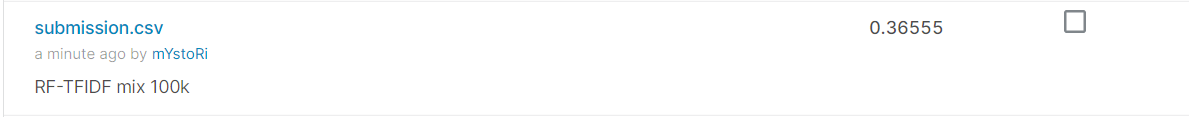

# Conclusion

That wraps up for me! Really want to play with this more but I still got things to do. It is a blast getting this course for me, I may not be the one with the highest score, but what I learned is not only about data mining, but also a lot of things beforehand. Machine learning, text manipulation, also working together with group members. These got me a great lesson and I'm very grateful of how this goes now.

If it's possible, I really want to see the feedback of this homework. I feel like going a lot of far paths during this and it would be nice to get a guide for it. 

Thanks for watching! That's really long considering it's just a homework. Hope the sorting of codes and explanation is adequate.

# References

`sklearn`: https://scikit-learn.org/stable/user_guide.html

`csv reading`: https://blog.gtwang.org/programming/python-csv-file-reading-and-writing-tutorial/

`emoticon dictionary`: https://github.com/wooorm/gemoji/blob/main/support.md

`index of dispersion`: https://en.wikipedia.org/wiki/Index_of_dispersion

`machine learning ideas`: https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi